### Import the required modules

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from classFraudClaimsMLMethods import *
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)

### Load the data into a dataframe

In [2]:
dfClaims = pd.read_csv('insurance_claims.csv')

### Data Dictionary

|Attribute| Description|
|:--------|:-----------|
|months_as_customer|Number of months, the customer is associated with the insurance firm.|
|age|age of the customer in years.|
|policy_number|policy number of the customer.|
|policy_bind_date|date of inception of the insurance policy.|
|policy_state|state in the US where the policy is applicable / US state where the policy holder resides.|
|policy_csl|combined single limit of the policy.Reference : https://www.investopedia.com/terms/c/combined-single-limits.asp |
|policy_deductible|In an insurance policy, the deductible is the amount paid out of pocket by the policy holder before an insurance provider will pay any expenses.|
|policy_annual_premium|An annual premium is a payment mode for insurance contracts.Typically an annual premium payment is considered the full yearly payment or a Paid in Full amount.|
|umbrella_limit|When an insured is liable to someone, the insured's primary insurance policies pay up to their limits, and any additional amount is paid by the umbrella policy (up to the limit of the umbrella policy).|
|insured_zip|Zip code of the policy holder.|
|insured_sex|Policy holder's gender.|
|insured_education_level|Policy holder's education.|
|insured_occupation|Policy holder's occupation.|
|insured_hobbies|Policy holder's hobbies.|
|insured_relationship|Policy holder's relationship.|
|capital_gains|Capital gains of the insurance proceeds.|
|capital_loss|Capital loss of the insurance proceeds.* |
|incident_date|Date of occurence of the incident.|
|incident_type|Type of incident.|
|collission_type|Collission type of the incident.|
|incident_severity|Severity of the incident.|
|authorities_contacted|Possible values : Ambulance|Fire|None|Other|Police|
|incident_state|US state, where the incident occurred.|
|incident_city|US city, where the incident occurred.|
|incident_location|Location in US, where the incident occurred.|
|incident_hour_of_the_day|Hour of the day, when the incident occurred.|
|number_of_vehicles_involved|Number of vehicles involved in the incident.|
|property_damage|Indicator whether the property was damaged during the collission.|
|bodily_injuries|Bodily injuries to the policy holder, if any.|
|witnesses|Witnesses to the incident, if any.|
|police_report_available|Is police report available?|
|total_claim_amount|Total amount claimed by the policy holder.|
|injury_claim|Amount claimed by the policy holder towards bodily injury.|
|property_claim|Amount claimed by the policy holder towards property damage.|
|vehicle_claim|Amount claimed by the policy holder towards vehicle damage.|
|auto_make|Automobile maker/manufacturer.|
|auto_model|Automobile model| 
|auto_year|Year the automobile model was launched.|
|fraud_reported|Is the claim, FRADULENT ? Yes/No.|
    
    
The art of effective visualization :
https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

### Explore the data

In [3]:
dfClaims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
months_as_customer             1000 non-null int64
age                            1000 non-null int64
policy_number                  1000 non-null int64
policy_bind_date               1000 non-null object
policy_state                   1000 non-null object
policy_csl                     1000 non-null object
policy_deductable              1000 non-null int64
policy_annual_premium          1000 non-null float64
umbrella_limit                 1000 non-null int64
insured_zip                    1000 non-null int64
insured_sex                    1000 non-null object
insured_education_level        1000 non-null object
insured_occupation             1000 non-null object
insured_hobbies                1000 non-null object
insured_relationship           1000 non-null object
capital-gains                  1000 non-null int64
capital-loss                   1000 non-null int64
incident_date    

### Identify non-numeric columns with high cardinality.

In [4]:
import numpy as np
import pandas as pd
lstAttrib = ['policy_number','policy_bind_date','policy_state','policy_csl','insured_zip','insured_sex',
             'insured_education_level','insured_occupation','insured_hobbies','insured_relationship',
             'incident_date','incident_type','collision_type','incident_severity','authorities_contacted',
             'incident_state','incident_city','incident_location','property_damage','police_report_available',
             'auto_make','auto_model']
lstAttribCardinality = []
for i in lstAttrib:
    lstAttribCardinality.append((len(set(dfClaims[i]))))

dictData = {'Attrib':lstAttrib,'Cardinality':lstAttribCardinality} 
dfAttribCardinality = pd.DataFrame(dictData)
dfAttribCardinalitySorted = dfAttribCardinality[['Attrib','Cardinality']].sort_values(by='Cardinality',ascending=True)
plot_y = list(dfAttribCardinalitySorted['Attrib'])
plot_x = list(dfAttribCardinalitySorted['Cardinality'])

### Plot non-numeric columns with high cardinality.

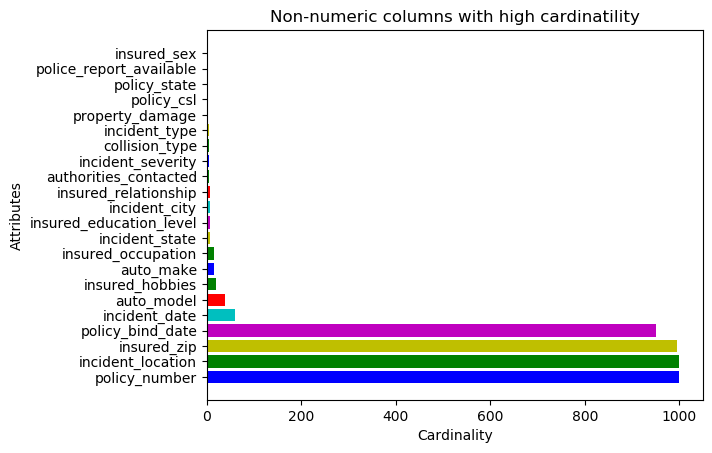

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Set the plot defaults
plt.rcdefaults()
fig, ax = plt.subplots()

# Set the colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g']

# Set the plot configs.
ax.barh(plot_y, plot_x, color = colors,align='center')
ax.set_yticks(plot_y)
ax.set_yticklabels(plot_y)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Cardinality')
ax.set_ylabel('Attributes')
ax.set_title('Non-numeric columns with high cardinatility')

#Show the plot.
plt.show()

### Observation :
    incident_location,policy_number and insured_zip have high cardinality and therefore could be dropped from the analysis.
    incident_date and policy_bind_date could be processed to consider the year and month part instead of the complete date.    

### Data pre-process the date columns.

In [6]:
# Inspect, each column for unusual values.
dfClaims['incident_date_converted']    = pd.to_datetime(dfClaims['incident_date'])
dfClaims['policy_bind_date_converted'] = pd.to_datetime(dfClaims['policy_bind_date'])

# Consider Month and Year part of date columns.
dfClaims['incident_date_year']         = dfClaims['incident_date_converted'].dt.year
dfClaims['incident_date_month']        = dfClaims['incident_date_converted'].dt.month
dfClaims['policy_bind_date_year']      = dfClaims['policy_bind_date_converted'].dt.year
dfClaims['policy_bind_date_month']     = dfClaims['policy_bind_date_converted'].dt.month

dfClaims = dfClaims.astype({"incident_date_year"      : str, 
                            "incident_date_month"     : str,
                            "policy_bind_date_year"   : str,
                            "policy_bind_date_month"  : str,
                            "auto_year"               : str
                           })

dfClaims['incident_date_final']        =  dfClaims['incident_date_year'] + \
                                          '-' + dfClaims['incident_date_month']

dfClaims['policy_bind_date_final']     =  dfClaims['policy_bind_date_year'] + \
                                          '-' + dfClaims['policy_bind_date_month']

In [7]:
dfClaims.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39,incident_date_converted,policy_bind_date_converted,incident_date_year,incident_date_month,policy_bind_date_year,policy_bind_date_month,incident_date_final,policy_bind_date_final
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN,2015-01-25,2014-10-17,2015,1,2014,10,2015-1,2014-10
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN,2015-01-21,2006-06-27,2015,1,2006,6,2015-1,2006-6
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN,2015-02-22,2000-09-06,2015,2,2000,9,2015-2,2000-9
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN,2015-01-10,1990-05-25,2015,1,1990,5,2015-1,1990-5
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN,2015-02-17,2014-06-06,2015,2,2014,6,2015-2,2014-6


### Identify and Handle Missing Values

In [8]:
#set(dfClaims['insured_sex'])              #{'FEMALE', 'MALE'}
#set(dfClaims['police_report_available'])  #{'?', 'NO', 'YES'}
#set(dfClaims['policy_state'])             #{'IL', 'IN', 'OH'}
#set(dfClaims['policy_csl'])               #{'100/300', '250/500', '500/1000'}
#set(dfClaims['property_damage'])          #{'?', 'NO', 'YES'}
#set(dfClaims['incident_type'])            #{'Multi-vehicle Collision','Parked Car','Single Vehicle Collision',
                                           # 'Vehicle Theft'}
#set(dfClaims['collision_type'])           #{'?', 'Front Collision', 'Rear Collision', 'Side Collision'}
#set(dfClaims['incident_severity'])        #{'Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage'}
#set(dfClaims['authorities_contacted'])    #{'Ambulance', 'Fire', 'None', 'Other', 'Police'}
#set(dfClaims['insured_relationship'])     #{'husband','not-in-family','other-relative','own-child',
                                           # 'unmarried','wife'}
#set(dfClaims['incident_city'])            #{'Arlington','Columbus','Hillsdale','Northbend',
                                           # 'Northbrook','Riverwood','Springfield'}
#set(dfClaims['insured_education_level'])  #{'Associate', 'College', 'High School', 'JD', 'MD', 'Masters', 'PhD'}
#set(dfClaims['incident_state'])           #{'NC', 'NY', 'OH', 'PA', 'SC', 'VA', 'WV'}
#set(dfClaims['insured_occupation'])       #{'adm-clerical','armed-forces','craft-repair','exec-managerial',
                                           # 'farming-fishing','handlers-cleaners','machine-op-inspct',
                                           # 'other-service','priv-house-serv','prof-specialty','protective-serv',
                                           # 'sales','tech-support','transport-moving'}
#set(dfClaims['auto_make'])                #{'Accura','Audi','BMW','Chevrolet','Dodge','Ford','Honda','Jeep',
                                           # 'Mercedes','Nissan','Saab','Suburu','Toyota','Volkswagen'}
#set(dfClaims['insured_hobbies'])          #{'base-jumping','basketball','board-games','bungie-jumping',
                                           # 'camping','chess','cross-fit','dancing','exercise','golf','hiking',
                                           # 'kayaking','movies','paintball','polo','reading','skydiving','sleeping',
                                           # 'video-games','yachting'}
#set(dfClaims['auto_model'])               #{'3 Series','92x','93','95','A3','A5','Accord','C300','CRV','Camry',
                                           # 'Civic','Corolla','E400','Escape','F150','Forrestor','Fusion',
                                           # 'Grand Cherokee','Highlander','Impreza','Jetta','Legacy','M5','MDX',
                                           # 'ML350','Malibu','Maxima','Neon','Passat','Pathfinder','RAM','RSX',
                                           # 'Silverado','TL','Tahoe','Ultima','Wrangler','X5','X6'}


### Observation : 
    Columns "police_report_available", "property_damage" and "collision_type" are found to have missing values.
    Handle missing values as separate category. Impute value '?' within 'Unknown'

### Check, for missing values and treat them as separate categories.

In [9]:
dfClaims[['incident_type','police_report_available','property_damage','collision_type']] \
[(dfClaims['police_report_available'] == '?') | (dfClaims['property_damage'] == '?') | \
(dfClaims['collision_type'] == '?')]

,incident_type,police_report_available,property_damage,collision_type
1,Vehicle Theft,?,?,?
3,Single Vehicle Collision,NO,?,Front Collision
4,Vehicle Theft,NO,NO,?
6,Multi-vehicle Collision,?,?,Front Collision
7,Multi-vehicle Collision,YES,?,Front Collision
9,Single Vehicle Collision,?,NO,Rear Collision
10,Single Vehicle Collision,?,YES,Front Collision
13,Parked Car,NO,NO,?
16,Multi-vehicle Collision,YES,?,Rear Collision
19,Multi-vehicle Collision,NO,?,Side Collision


### Update missing values.

In [10]:
# Update missing column values '?' with 'Unknown'.
dfClaims.loc[dfClaims['police_report_available'] == '?','police_report_available'] = 'Unknown'
dfClaims.loc[dfClaims['property_damage'] == '?','property_damage'] = 'Unknown'
dfClaims.loc[dfClaims['collision_type'] == '?','collision_type'] = 'Unknown'

In [11]:
# Exclude columns "policy_number","insured_zip","incident_location"
cols = ['months_as_customer', 'age', 'policy_bind_date_final','policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_sex','insured_education_level', 'insured_occupation', 
        'insured_hobbies','insured_relationship', 'capital-gains', 'capital-loss','incident_date_final', 'incident_type', 
        'collision_type', 'incident_severity','authorities_contacted', 'incident_state', 'incident_city',
       'incident_hour_of_the_day','number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','injury_claim', 'property_claim', 'vehicle_claim', 
        'auto_make','auto_model', 'auto_year', 'fraud_reported']

dfClaimInter = dfClaims[cols]
dfClaimInter.head()

,months_as_customer,age,policy_bind_date_final,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date_final,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,2014-10,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-1,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,2006-6,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-1,Vehicle Theft,Unknown,Minor Damage,Police,VA,Riverwood,8,1,Unknown,0,0,Unknown,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,2000-9,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-2,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,1990-5,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-1,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,Unknown,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,2014-6,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-2,Vehicle Theft,Unknown,Minor Damage,None,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


#### Perform Frequency Encoding of Categorical features.
Reference : https://medium.com/analytics-vidhya/different-type-of-feature-engineering-encoding-techniques-for-categorical-variable-encoding-214363a016fb

In [12]:
'''
colsCategory = ['policy_bind_date_final','policy_state','policy_csl','insured_sex','insured_education_level',
                'insured_occupation','insured_hobbies','insured_relationship','incident_date_final','incident_type',
                'collision_type','incident_severity','authorities_contacted','incident_state','incident_city',
                'property_damage','police_report_available','auto_make','auto_model','auto_year','fraud_reported']

dfClaimCategory = dfClaims[colsCategory].copy()
'''

"\ncolsCategory = ['policy_bind_date_final','policy_state','policy_csl','insured_sex','insured_education_level',\n                'insured_occupation','insured_hobbies','insured_relationship','incident_date_final','incident_type',\n                'collision_type','incident_severity','authorities_contacted','incident_state','incident_city',\n                'property_damage','police_report_available','auto_make','auto_model','auto_year','fraud_reported']\n\ndfClaimCategory = dfClaims[colsCategory].copy()\n"

In [13]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(dfClaimInter.isnull().any()))

No of Nan values in our dataframe :  0


### Univariate Analysis

In [14]:
'''
# List of features for the analysis.
lstUnivariates = ['months_as_customer', 'age', 'policy_deductable','policy_annual_premium',
                  'umbrella_limit','capital-gains','capital-loss','incident_hour_of_the_day',
                  'number_of_vehicles_involved','witnesses','total_claim_amount',
                  'injury_claim', 'property_claim', 'vehicle_claim']

# Loop thru the list of features and perform Univariate analysis.
for itm in lstUnivariates:
    # 1D analysis using Histograms for features in lstUnivariates
    sns.FacetGrid(dfClaimInter,hue="fraud_reported",height=5) \
       .map(sns.distplot,itm) \
       .add_legend();
    plt.title("Univariate Analysis for feature : " + itm)
    plt.show();
'''

'\n# List of features for the analysis.\nlstUnivariates = [\'months_as_customer\', \'age\', \'policy_deductable\',\'policy_annual_premium\',\n                  \'umbrella_limit\',\'capital-gains\',\'capital-loss\',\'incident_hour_of_the_day\',\n                  \'number_of_vehicles_involved\',\'witnesses\',\'total_claim_amount\',\n                  \'injury_claim\', \'property_claim\', \'vehicle_claim\']\n\n# Loop thru the list of features and perform Univariate analysis.\nfor itm in lstUnivariates:\n    # 1D analysis using Histograms for features in lstUnivariates\n    sns.FacetGrid(dfClaimInter,hue="fraud_reported",height=5)        .map(sns.distplot,itm)        .add_legend();\n    plt.title("Univariate Analysis for feature : " + itm)\n    plt.show();\n'

### Multi-variate Analysis

In [15]:
'''
# Use pair plots to determine usefull features that determine the class label.
lstMultivariates = ['months_as_customer', 'age', 'policy_deductable','policy_annual_premium','umbrella_limit'
                    ,'capital-gains','capital-loss','incident_hour_of_the_day','number_of_vehicles_involved','witnesses'
                    ,'total_claim_amount','injury_claim', 'property_claim', 'vehicle_claim']
mvCols = []
mvCols = lstMultivariates.copy()
mvCols.append('fraud_reported')

plt.close
sns.set_style("whitegrid");
sns.pairplot(dfClaimInter[mvCols], hue="fraud_reported", height=10);
plt.title("Pair Plot")
plt.show()
'''

'\n# Use pair plots to determine usefull features that determine the class label.\nlstMultivariates = [\'months_as_customer\', \'age\', \'policy_deductable\',\'policy_annual_premium\',\'umbrella_limit\'\n                    ,\'capital-gains\',\'capital-loss\',\'incident_hour_of_the_day\',\'number_of_vehicles_involved\',\'witnesses\'\n                    ,\'total_claim_amount\',\'injury_claim\', \'property_claim\', \'vehicle_claim\']\nmvCols = []\nmvCols = lstMultivariates.copy()\nmvCols.append(\'fraud_reported\')\n\nplt.close\nsns.set_style("whitegrid");\nsns.pairplot(dfClaimInter[mvCols], hue="fraud_reported", height=10);\nplt.title("Pair Plot")\nplt.show()\n'

#### Instantiate the class

In [16]:
applConfig = fraudClaimsMLMethodsPipeline('1001','Crawford')
skipTNSE   = 0

#### Use T-SNE plots to visualize data patterns from high dimension to low dimension excluding categorical features.

In [17]:
if skipTNSE == 1:
    
    from sklearn.manifold import TSNE
    import seaborn as sn

    colsForML = ['fraud_reported','months_as_customer','age','policy_deductable','policy_annual_premium','umbrella_limit',
                 'capital-gains','capital-loss','incident_hour_of_the_day','number_of_vehicles_involved','bodily_injuries',
                 'witnesses','total_claim_amount','injury_claim','property_claim','vehicle_claim']

    dataWOCatFeatures = dfClaimInter[colsForML].copy()

    # Need to convert the class lable from Y/N to 1/0.
    dataWOCatFeatures['IsFraud'] = 0
    dataWOCatFeatures.loc[dataWOCatFeatures['fraud_reported'] == 'Y','IsFraud'] = 1

    # Split data into dependent and independent features.
    dfDataWOCatFeaturesOutput = dataWOCatFeatures['IsFraud'].copy()
    dfDataWOCatFeaturesInput  = dataWOCatFeatures.copy()
    dfDataWOCatFeaturesInput.drop(['fraud_reported','IsFraud'], axis=1,inplace=True)

    # Perform train-test splitting of the data.

    # Get the total row count.
    total_rowCount = len(dfDataWOCatFeaturesInput)
    # Is time based splitting of dataset required.
    IsTimeBasedSplitting = 0
    # Data split ratio for train, cv and test set.
    Training_split_ratio = 0.60
    Crossvalidation_split_ratio = 0.20
    Test_split_ratio = 0.20

    # Call the method to split the data.
    X_train_Wo_Cat,X_cv_Wo_Cat,X_test_Wo_Cat, \
    Y_train_Wo_Cat,Y_cv_Wo_Cat,Y_test_Wo_Cat = \
                                        applConfig.split_data(dfX = dfDataWOCatFeaturesInput,
                                                              dfY = dfDataWOCatFeaturesOutput,
                                                              total_rowCount = total_rowCount,
                                                              IsTimeBasedSplitting = IsTimeBasedSplitting,
                                                              Training_split_ratio = Training_split_ratio,
                                                              Crossvalidation_split_ratio = Crossvalidation_split_ratio,
                                                              Test_split_ratio = Test_split_ratio)

    # Standardize the data
    # Choose either Standardize / Normalize
    IsNormalize         = 3
    # Standardize the data.
    normalizer,X_train_Wo_Cat_stdzd,X_cv_Wo_Cat_stdzd, X_test_Wo_Cat_stdzd, \
    Y_train_Wo_Cat_ravel,Y_cv_Wo_Cat_ravel,Y_test_Wo_Cat_ravel = applConfig.standardize_data( X_train_Wo_Cat,
                                                                         X_cv_Wo_Cat,
                                                                         X_test_Wo_Cat,
                                                                         Y_train_Wo_Cat,
                                                                         Y_cv_Wo_Cat,
                                                                         Y_test_Wo_Cat,
                                                                         IsNormalize=IsNormalize)

    # Stack the standardized data into a single dataframe.
    dataStacked_X    = np.vstack((X_train_Wo_Cat_stdzd,X_cv_Wo_Cat_stdzd,X_test_Wo_Cat_stdzd))
    dataStacked_Y    = np.vstack((Y_train_Wo_Cat_ravel.reshape((Y_train_Wo_Cat_ravel.shape[0],1)), \
                                  Y_cv_Wo_Cat_ravel.reshape((Y_cv_Wo_Cat_ravel.shape[0],1)), \
                                  Y_test_Wo_Cat_ravel.reshape((Y_test_Wo_Cat_ravel.shape[0],1)))) 
    dataStacked_Y    = np.ravel(dataStacked_Y, order = 'C')

    # Split Dependent and Independent variables into their respective arrays.
    data             = dataStacked_X
    labels           = dataStacked_Y

    # Configure the parameters for the tsne plot.
    sPerplexity      = 50
    step             = 5000

    # Run tsne plot for the above congif, in multiple iterations.
    for itr in np.arange(4):
        # Instantiate the tsne component.
        model       = TSNE(n_components=2, learning_rate=200,random_state=0, \
                           perplexity=sPerplexity,  n_iter=step)
        # fit the tsne method on data.
        tsne_data   = model.fit_transform(data) 
        # creating a new data from which help us in ploting the result data
        tsne_data   = np.vstack((tsne_data.T, labels)).T
        tsne_df     = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
        # Ploting the result of tsne
        sn.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
        plt.title('Iteration = ' + str(itr+1) + '; With perplexity = ' + str(sPerplexity) + ' and Step = ' + str(step))
        plt.show()


### Feature Engineering

#### Features required for ML

In [18]:
# Categorical variables to be encoded.
lstCatAttrib = [ 'policy_bind_date_final','policy_state','policy_csl','insured_sex',
                 'insured_education_level','insured_occupation','insured_hobbies','insured_relationship',
                 'incident_date_final','incident_type','collision_type','incident_severity','authorities_contacted',
                 'incident_state','incident_city','property_damage','police_report_available',
                 'auto_make','auto_model','auto_year']

# Discrete/Continuous variables required for ML.
colsForML = ['fraud_reported','months_as_customer','age','policy_deductable','policy_annual_premium','umbrella_limit',
             'capital-gains','capital-loss','incident_hour_of_the_day','number_of_vehicles_involved','bodily_injuries',
             'witnesses','total_claim_amount','injury_claim','property_claim','vehicle_claim']

# Dataframe with Discrete/Continuous variables required for ML.
dfDataForML = dfClaimInter[colsForML]

In [19]:
# Set the encode type.
# OHE := One Hot Encoding| FE :
EncodeType = 'OHE'
#EncodeType = 'FE'

#### OneHot Encode categorical data

In [20]:
if EncodeType == 'OHE':    
    # List containing the dataframes of OHE features.
    lstDataframes = []
    # Perform OHE of categorical features.
    for itm in lstCatAttrib:
        # Build the dataframe with the encoded column for the categorical data.
        dfOHE = pd.get_dummies(dfClaimInter[itm])
        # Append the dataframe to the list.
        lstDataframes.append(dfOHE)
        del dfOHE
    # Merge dataframe with OHE features into the main dataframe.
    dfDataOHEFeatures = pd.concat(lstDataframes,axis=1)
    dfDataForML = pd.concat([dfDataForML,dfDataOHEFeatures],axis=1)
    del dfDataOHEFeatures

#### Frequency Encode the categorical data

In [21]:
if EncodeType == 'FE':
    dfClaimAll = dfClaimInter.copy()
    dfClaimCategory = dfClaims[lstCatAttrib].copy()
    dfClaimCategory['fraud_reported'] = dfClaims['fraud_reported'].copy()
    # List containing the dataframes of Frequency Encoded features.
    lstDataframes = []
    # Total records in dataframe.
    recCount = len(dfClaimCategory)
    # Perform FE of categorical features.
    for itm in lstCatAttrib:
        colName = itm
        colNameFe = itm + '_fe'
        # Build the dataframe with the freq. encoded column for the categorical data.
        # Get the frequency of occurence.
        dfFE = dfClaimCategory.groupby([colName]).agg({'fraud_reported':'count'}) \
                                                     .reindex(['fraud_reported'],axis=1) \
                                                     .reset_index()
        # Get the relative frequency of occurence.
        dfFE[colNameFe] = dfFE['fraud_reported']/recCount
        dfFE.drop(['fraud_reported'], axis=1,inplace=True)
        # Update the relative freq. count back to the main dataframe.
        dfClaimAll = dfClaimAll.merge(dfFE,on=[colName],how='inner')
        # drop the intermediate dataframe.
        del dfFE
        
    # Drop the Non-encoded categorical features.
    dfClaimAll.drop(lstCatAttrib, axis=1,inplace=True)
    # Set the features for ML
    dfDataForML = dfClaimAll.copy()

#### Split data into Input and Output dataframes for ML.

In [22]:
# Need to convert the class lable from Y/N to 1/0.
dfDataForML['IsFraud'] = 0
dfDataForML.loc[dfDataForML['fraud_reported'] == 'Y','IsFraud'] = 1
dfDataOutput = dfDataForML['IsFraud'].copy()
dfDataInput  = dfDataForML.copy()
dfDataInput.drop(['fraud_reported','IsFraud'], axis=1,inplace=True)

#### Split the input/output features into train,cv and test sets.

In [23]:
# Get the total row count.
total_rowCount = len(dfDataInput)
# Is time based splitting of dataset required.
IsTimeBasedSplitting = 0
# Data split ratio for train, cv and test set.
Training_split_ratio = 0.60
Crossvalidation_split_ratio = 0.20
Test_split_ratio = 0.20

# Call the method to split the data.
X_train,X_cv,X_test,Y_train,Y_cv,Y_test = applConfig.split_data(dfX = dfDataInput,
                                                                dfY = dfDataOutput,
                                                                total_rowCount = total_rowCount,
                                                                IsTimeBasedSplitting = IsTimeBasedSplitting,
                                                                Training_split_ratio = Training_split_ratio,
                                                                Crossvalidation_split_ratio = Crossvalidation_split_ratio,
                                                                Test_split_ratio = Test_split_ratio)

#### Standardize the data.

In [24]:
# Choose either Standardize / Normalize
IsNormalize         = 0
# Standardize the data.
normalizer,X_train_stdzd,X_cv_stdzd, X_test_stdzd, \
Y_train_ravel,Y_cv_ravel,Y_test_ravel = applConfig.standardize_data( X_train,
                                                                     X_cv,
                                                                     X_test,
                                                                     Y_train,
                                                                     Y_cv,
                                                                     Y_test,
                                                                     IsNormalize=IsNormalize)

#### Get the model hyper-parameters.

In [25]:
# Specify Algorithm Type.
modelCode = "LgR_1001" # Logistic Regression with L1 regularizer.
# Get the model hyper-parameters.
gridResults,bestScore, \
optimal_HyperParameter = applConfig.GetModelHyperParameters(X_train_stdzd
                                                            ,Y_train_ravel
                                                            ,modelCode)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
print('Best Score : {}'.format(bestScore))
print('Optimal_HyperParameter : {}'.format(optimal_HyperParameter))
print('GridResults : {}'.format(gridResults))

Best Score : 0.8533333333333334
Optimal_HyperParameter : 0.1
GridResults : GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)


#### Perform training, evaluation and testing the trained model.

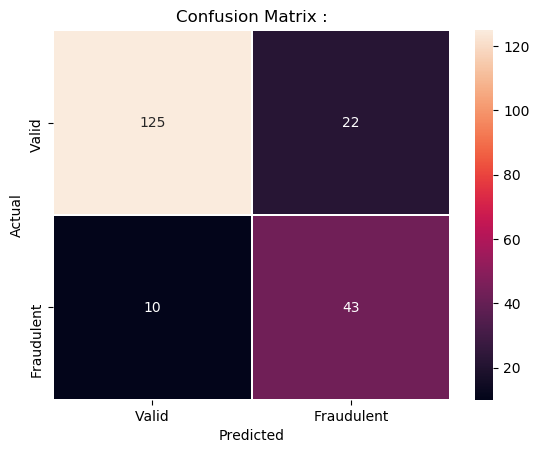

In [27]:
#https://indianaiproduction.com/seaborn-heatmap/

# Set the optimalHyperParameter.
dictOptimalHyperParameter = {"lambda":str(optimal_HyperParameter)}
# Get the trained model with the optimal hyperparameter.
lr_optimal = applConfig.GetTrainedModel(X_train_stdzd,
                                        Y_train_ravel,
                                        dictOptimalHyperParameter,
                                        modelCode)

# Get the calibrated model.
calibratedCCV = applConfig.GetCalibratedModel( lr_optimal,
                                               X_train_stdzd,
                                               Y_train_ravel)

# Get the predictions from the test set.
Y_pred_test = applConfig.GetPredictions( lr_optimal,
                                         X_test_stdzd)

# Get the calibrated predictions from the test set.
Y_pred_calib = applConfig.GetCalibratedPredictions( calibratedCCV,
                                                    X_test_stdzd)

# Get the model confusion matrix
_ , confmat, \
tn, fp, fn, tp = applConfig.GetModelConfusionMatrixForBinaryClass(Y_test,
                                                                  Y_pred_test)
# Reference : https://indianaiproduction.com/seaborn-heatmap/
ax = sns.heatmap(confmat,annot=True,fmt='d',linewidths=.5
                 ,xticklabels=['Valid','Fraudulent'], yticklabels=['Valid','Fraudulent']
                 ,annot_kws={'horizontalalignment':'center'})
# Manually set the Y-limits of the plot. Issue with matplotlib version 3.1.1
# Reference : https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
ax.set_ylim(2.0, 0) #print(ax.get_ylim())

plt.title('Confusion Matrix :')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
print(Y_test.value_counts())

0    147
1     53
Name: IsFraud, dtype: int64


#### Plot the RoC curve

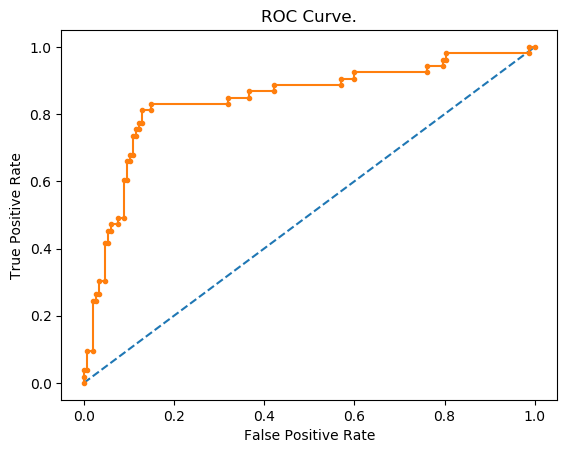

In [29]:
plt,roc_score = applConfig.GetModelROCForBinaryClass(Y_test_ravel,Y_pred_calib)

In [30]:
print(roc_score)

0.8428956488255679
